# TCF7 analysis - survvial curves, correlation, boxplot
Figure 3C, Extended Figure 3D-F, Supplementary Figure 3F

- Author: CW
- files needed: CD8T_cells.rds (if calculating TCF7 ratio), Supplementary_Table_1.csv, clinical_variable_analysis/scCancer_metadata_35_samples_w_TCF7.csv, 
- Last updated: 04/10/24

In [24]:
library(Seurat)
library(ggpubr)
library(ggplot2)
library(survival)
library(ggsurvfit)

Attaching SeuratObject

‘SeuratObject’ was built with package ‘Matrix’ 1.6.4 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode



## 0. get TCF7 data (only do once)

In [2]:
CD8_T <- readRDS('/path_to_file/5_CD8T_cells.rds')

For each sample’s CD8 T cells, how many expressed TCF7 vs not expressed.

In [3]:
CD8_T

An object of class Seurat 
48572 features across 21710 samples within 3 assays 
Active assay: SCT (18536 features, 0 variable features)
 2 other assays present: RNA, integrated
 4 dimensional reductions calculated: pca, umap, DC, harmony

In [3]:
DefaultAssay(CD8_T) <- 'RNA'

In [4]:
## categorize samples with TCF7 expression 
CD8_T$TCF7 <- ifelse(CD8_T@assays$RNA@data['TCF7', ] > 0, 
                           1, 0)

In [54]:
TCF7_data <- c()
sample_ID <- c()

for (sample in unique(CD8_T$sample_ID_long)) {
    
    sample_ID <- append(sample_ID, sample )

    total_num_cells <- dim(CD8_T@meta.data[CD8_T@meta.data$sample_ID_long == sample,])[1]
    total_TCF7_pos <- sum(CD8_T@meta.data[CD8_T@meta.data$sample_ID_long == sample,]$TCF7)
    TCF7_ratio <- total_TCF7_pos/(total_num_cells- total_TCF7_pos)
    
    TCF7_data <- append(TCF7_data, TCF7_ratio)
}

In [19]:
sample_ID

[1] "D19-11962"  "D19-11990"  "D19-9123"   "D19-6307"   "D18-11808" 
 [6] "D18-11809"  "D19-284"    "D19-288"    "D19-289"    "D19-290"   
[11] "D19-1690"   "D19-1691"   "D19-1692"   "D19-9118"   "D19-6313"  
[16] "D19-11999"  "D19-12000"  "D19-11963"  "D19-11964"  "D19-11965" 
[21] "D19-11966"  "D19-11969"  "D19-11971"  "D19-11960"  "D19-11989" 
[26] "D19-11994"  "D19-11995"  "D19-11997"  "D21-194002" "D21-194004"
[31] "D21-194005" "D21-194006" "D21-194009" "D21-194010" "D21-194011"

In [55]:
TCF7_data

[1] 0.027397260 0.010666667 0.030612245 0.032786885 0.106100796 0.052760137
 [7] 0.066666667 0.122950820 0.131147541 0.131868132 0.204035874 0.161520190
[13] 0.346534653 0.437500000 0.030303030 0.428044280 0.113636364 0.058139535
[19] 0.093506494 0.154471545 0.234256927 0.180769231 0.937500000 0.135076253
[25] 0.029324056 0.120805369 0.092391304 0.076481836 0.004878049 0.146938776
[31] 0.070967742 0.162020906 0.307692308 0.035437431 0.146360153

Warning message:
“The following variables were found in both object metadata and the default assay: TCF7
Returning metadata; if you want the feature, please use the assay's key (eg. sct_TCF7)”


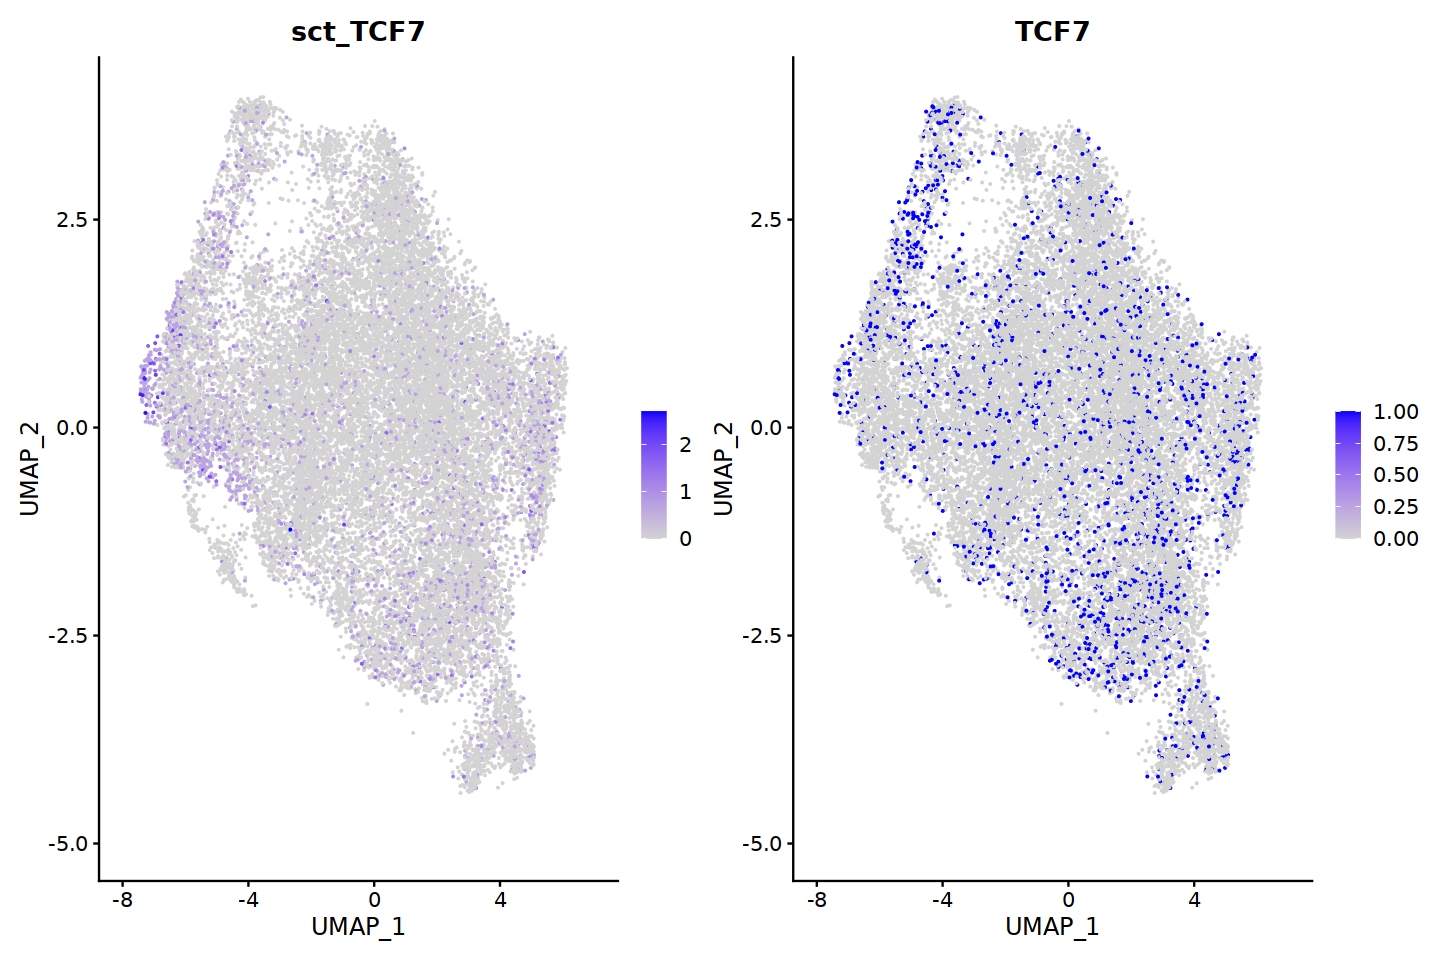

In [16]:
DefaultAssay(CD8_T) <- 'SCT'
options(repr.plot.height = 8, repr.plot.width = 12)
FeaturePlot(CD8_T, features = c('sct_TCF7', 'TCF7') ,ncol = 2)

In [56]:
TCF_7_df <- data.frame(sample_ID, TCF7_data)
#save file
write.csv(TCF_7_df, './TCF7_by_sample.csv' )

In [2]:
TCF7_data <- read.csv('./TCF7_by_sample.csv', row.names= 'X' )
colnames(TCF7_data)[1] <- 'sample_ID_long'
TCF7_data

,sample_ID_long,TCF7_data
,<chr>,<dbl>
1,D19-11962,0.027397260
2,D19-11990,0.010666667
3,D19-9123,0.030612245
4,D19-6307,0.032786885
5,D18-11808,0.106100796
6,D18-11809,0.052760137
7,D19-284,0.066666667
8,D19-288,0.122950820
9,D19-289,0.131147541


In [36]:
clinical_metadata =read.csv('./clinical_var_analysis/Supplementary_Table_1.csv', row.names = 'X')

### merge clinical data with TCF7 samples

In [5]:
clinical_w_mDC_TCF7 <- merge(clinical_w_mDC_TCF7,TCF7_data, by="sample_ID_long") #.join(, by = 'sample_ID_long')

In [54]:
#add TCF7_data to clinical metadata
write.csv(clinical_w_mDC_TCF7, '/path_to_file/scCancer_metadata_35_samples_w_TCF7.csv')

# 1. load TCF7 + clinical data

In [54]:
clinical_w_mDC_TCF7 <- read.csv('./clinical_var_analysis/scCancer_metadata_35_samples_w_TCF7.csv', row.names = 'X')

In [55]:
ggplotRegression <- function (fit, df) {

require(ggplot2)
response = df$response_short
    
ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1])) +
  geom_point(aes(colour=response), size = 2.5) + scale_color_manual(values=c("#FA7F72",  "#90EF91")) +
  stat_smooth(method = "lm", col = "black") +
  labs(title = "Correlation between mDC relative proportion and TCF7+/- ratio", 
      y= "TCF7+/-", x = "/cDC") + 
   annotate("text", x=0.4, y= 0.5,label= paste("r2=",signif(summary(fit)$r.squared, 3), "\n", 
                     " p=",signif(summary(fit)$coefficients[,4], 3))) +
    theme(panel.background = element_blank(), panel.border = element_blank(),
      panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black"), 
        legend.position = "right", 
        text = element_text(size = 14), 
         aspect.ratio=1) 

}

## Correlation between mDC relative proportion and TCF7+/- ratio - Extended Figure 3D

In [56]:
#no intercept 
fit1 <- lm(TCF7_data ~ 0 + mDC_out_of_cDC, data = clinical_w_mDC_TCF7)  
summary(fit1)


Call:
lm(formula = TCF7_data ~ 0 + mDC_out_of_cDC, data = clinical_w_mDC_TCF7)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20813 -0.04335  0.01840  0.12566  0.77202 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
mDC_out_of_cDC   0.7033     0.1570    4.48 8.03e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1859 on 34 degrees of freedom
Multiple R-squared:  0.3712,	Adjusted R-squared:  0.3527 
F-statistic: 20.07 on 1 and 34 DF,  p-value: 8.031e-05


`geom_smooth()` using formula = 'y ~ x'


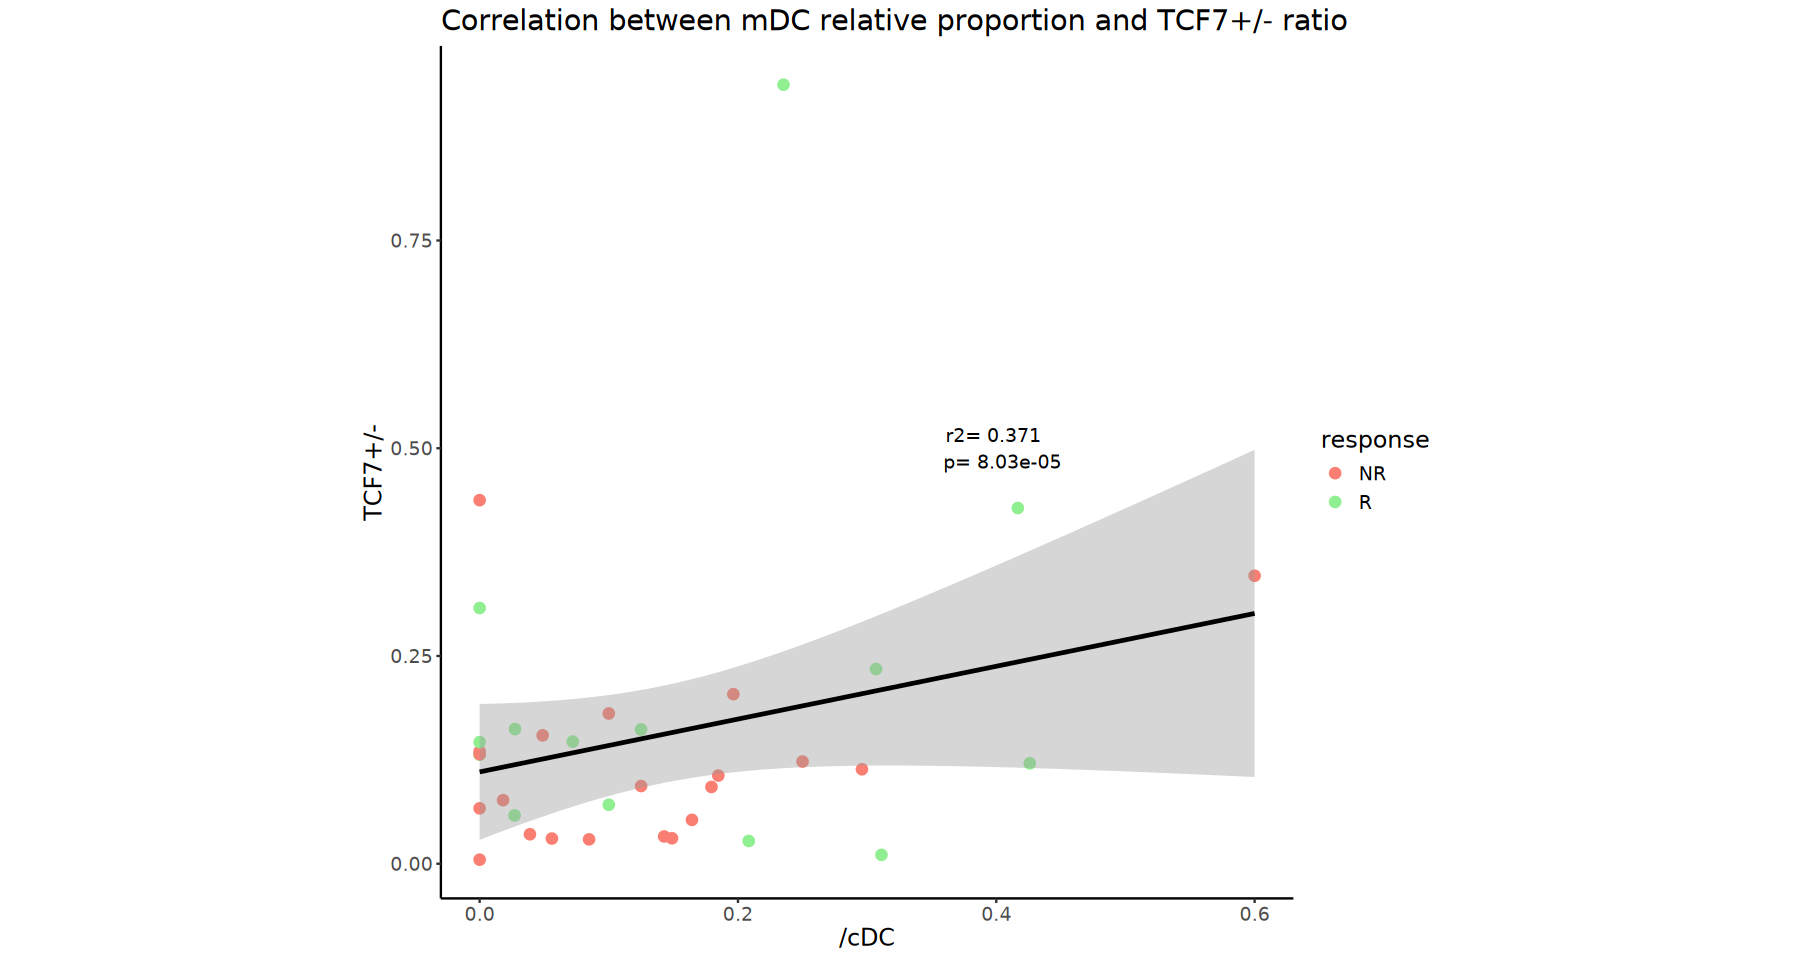

In [57]:
options(repr.plot.width=15, repr.plot.height=8)
ggplotRegression(fit1,clinical_w_mDC_TCF7 )

# Figure 3F: TCF7+/- ratio comparing R and NR Boxplot

### 1. all samples

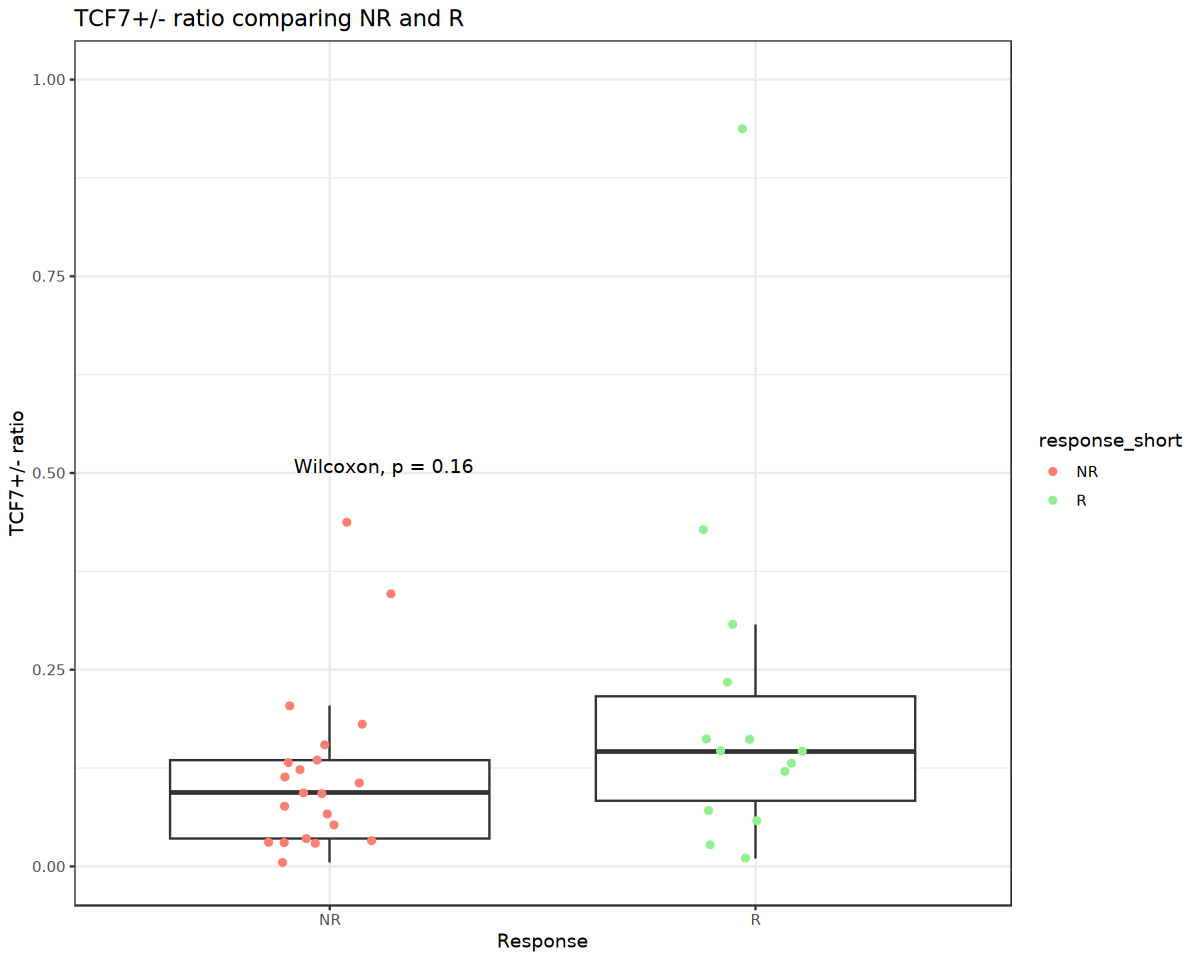

In [58]:
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(clinical_w_mDC_TCF7, aes_string('response_short', "TCF7_data")) +
                           ylim(0, 1) +
        geom_boxplot(fill='white', aes(group=response_short), outlier.shape = NA) +
        geom_jitter(aes(color=response_short), width=0.15, size = 1.5) + 
                    scale_color_manual(values = c("NR" = "#FA7F72", "R" = "#90EF91"))+
            stat_compare_means(label.y = 0.5)  + theme_bw()  +
       ggtitle(paste0("TCF7+/- ratio comparing NR and R")) + labs(x="Response", y=
                                                            'TCF7+/- ratio') 

### 2. samples with ICI (n = 29)

In [59]:
clinical_w_mDC_TCF7_with_ICI <- clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$with_ICI == 'yes',]

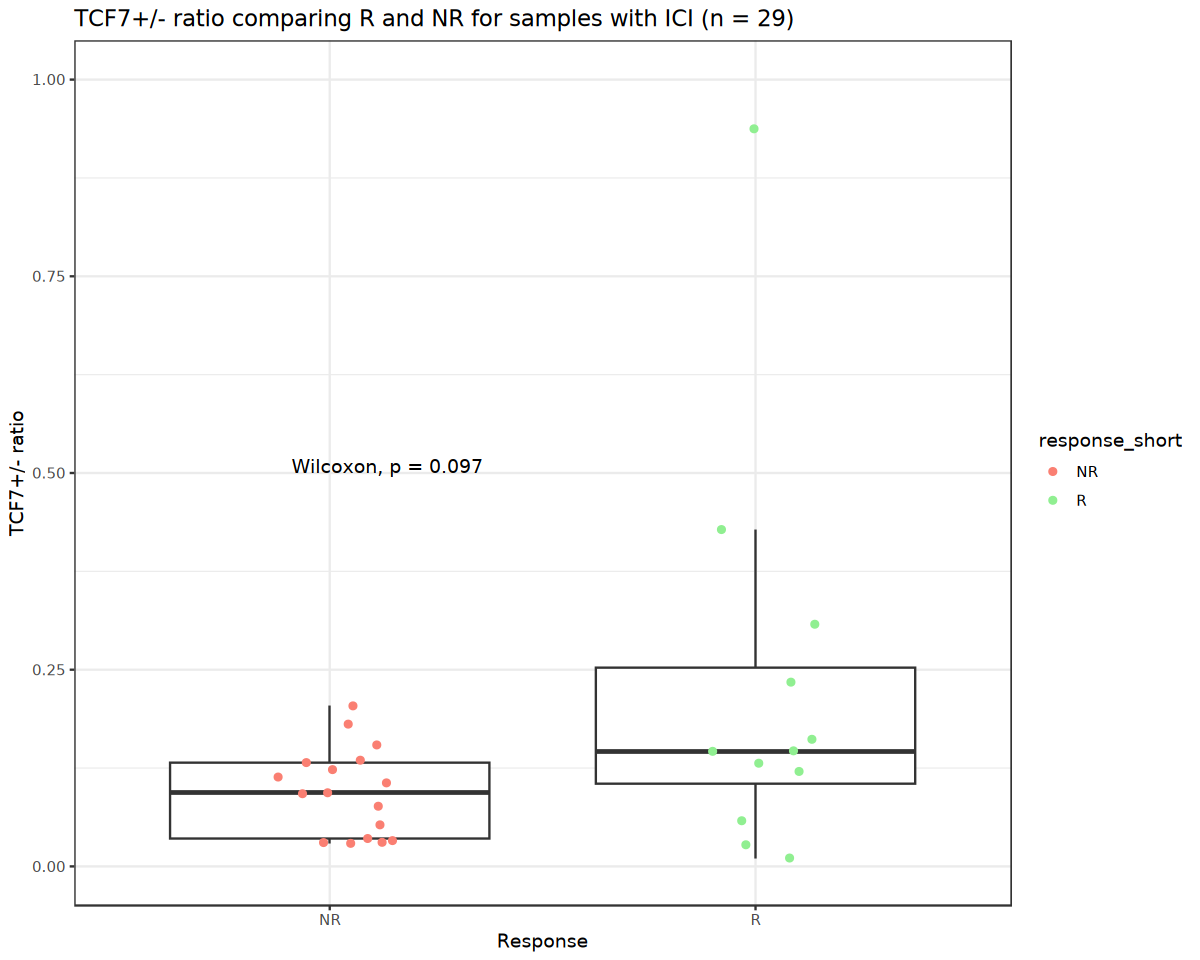

In [60]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(clinical_w_mDC_TCF7_with_ICI, aes_string('response_short', "TCF7_data")) +
                           ylim(0, 1) +
        geom_boxplot(fill='white', aes(group=response_short), outlier.shape = NA) +
        geom_jitter(aes(color=response_short), width=0.15, size = 1.5) + 
                    scale_color_manual(values = c("NR" = "#FA7F72", "R" = "#90EF91"))+
            stat_compare_means(label.y = 0.5)  + theme_bw()  +
       ggtitle(paste0("TCF7+/- ratio comparing R and NR for samples with ICI (n = 29)")) + labs(x="Response", y=
                                                            'TCF7+/- ratio')                      

### ICI only samples (n = 17) - Extended Figure 3E

In [61]:
clinical_w_mDC_TCF7_ICI_only <- clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$ICI_only == 'yes',]

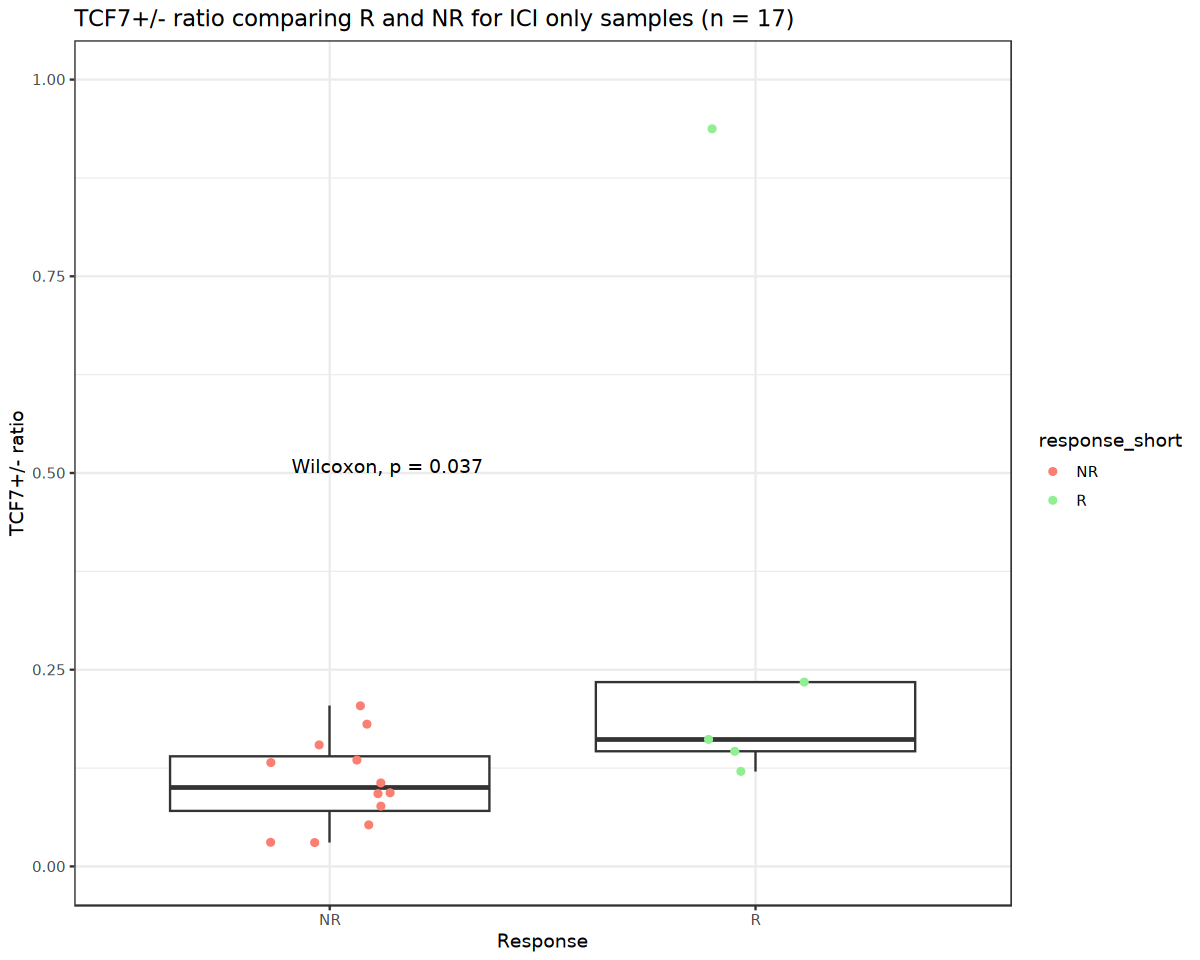

In [62]:
## EXTENDED FIGURE 3E
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(clinical_w_mDC_TCF7_ICI_only, aes_string('response_short', "TCF7_data")) +
                           ylim(0, 1) +
        geom_boxplot(fill='white', aes(group=response_short), outlier.shape = NA) +
        geom_jitter(aes(color=response_short), width=0.15, size = 1.5) + 
                    scale_color_manual(values = c("NR" = "#FA7F72", "R" = "#90EF91"))+
            stat_compare_means(label.y = 0.5)  + theme_bw()  +
       ggtitle(paste0("TCF7+/- ratio comparing R and NR for ICI only samples (n = 17)")) + labs(x="Response", y=
                                                            'TCF7+/- ratio') 

## Survival curves for varying treatment group cohorts 
TCF7+/- cutoff: 0.1

In [63]:
#Plotting function
plot_survival <- function(fit, type_of_surv, title) {
     fit %>% ggsurvfit() +
  labs(
    x = paste0(type_of_surv,", days"),
    y = "survival probability",
  title = title) + 
       add_legend_title("mDC/cDC and TCF7+/- status") +
    scale_color_manual(values = c( '#FE7201', '#226E01')) +
      scale_fill_manual(values = c('#FE7201', '#226E01')) +
    scale_y_continuous(limits = c(0, 1), breaks = c(0.00, 0.25, 0.50, 0.75, 1.00))  +
  add_confidence_interval() +
  add_risktable(size = 4) +  
      add_pvalue("annotation", x = 800, y = 0.15, size = 5) +  #change x and y 
      theme(panel.background = element_blank(), panel.border = element_blank(),
      panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black"), 
        legend.position = "right", 
        text = element_text(size = 12)) 
#, axis.line = element_line(colour = "black"),
 }

In [64]:
clinical_w_mDC_TCF7 <- read.csv('./clinical_var_analysis/scCancer_metadata_35_samples_w_TCF7.csv', 
                                  row.names = 'X')

In [65]:
clinical_w_mDC_TCF7$TCF7_status <- 'none'

In [66]:
#stratify TCF7+/- ratio high and low 
clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$TCF7_data >= 0.1,]$TCF7_status = 'high'

clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$TCF7_data < 0.1,]$TCF7_status = 'low'

### 1. all samples (n = 35) - Supplementary Figure 3F 

List of 18
 $ n           : int [1:2] 20 15
 $ time        : num [1:29] 42 54 61 67 68 84 92 108 110 131 ...
 $ n.risk      : num [1:29] 20 19 18 17 15 14 13 12 11 8 ...
 $ n.event     : num [1:29] 1 1 1 2 1 1 1 1 3 1 ...
 $ n.censor    : num [1:29] 0 0 0 0 0 0 0 0 0 0 ...
 $ surv        : num [1:29] 0.95 0.9 0.85 0.75 0.7 0.65 0.6 0.55 0.4 0.35 ...
 $ std.err     : num [1:29] 0.0513 0.0745 0.0939 0.1291 0.1464 ...
 $ cumhaz      : num [1:29] 0.05 0.103 0.158 0.276 0.343 ...
 $ std.chaz    : num [1:29] 0.05 0.0726 0.0914 0.1236 0.1404 ...
 $ strata      : Named int [1:2] 16 13
  ..- attr(*, "names")= chr [1:2] "TCF7_status=high" "TCF7_status=low"
 $ type        : chr "right"
 $ logse       : logi TRUE
 $ conf.int    : num 0.95
 $ conf.type   : chr "log"
 $ lower       : num [1:29] 0.859 0.778 0.707 0.582 0.525 ...
 $ upper       : num [1:29] 1 1 1 0.966 0.933 ...
 $ call        : language survfit(formula = Surv(pfs, censure_pfs) ~ TCF7_status, data = clinical_w_mDC_TCF7)
 $ .Environmen

Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 31 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 31 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 31 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 31 rows.
ℹ Did you mean to use `annotate()`?”


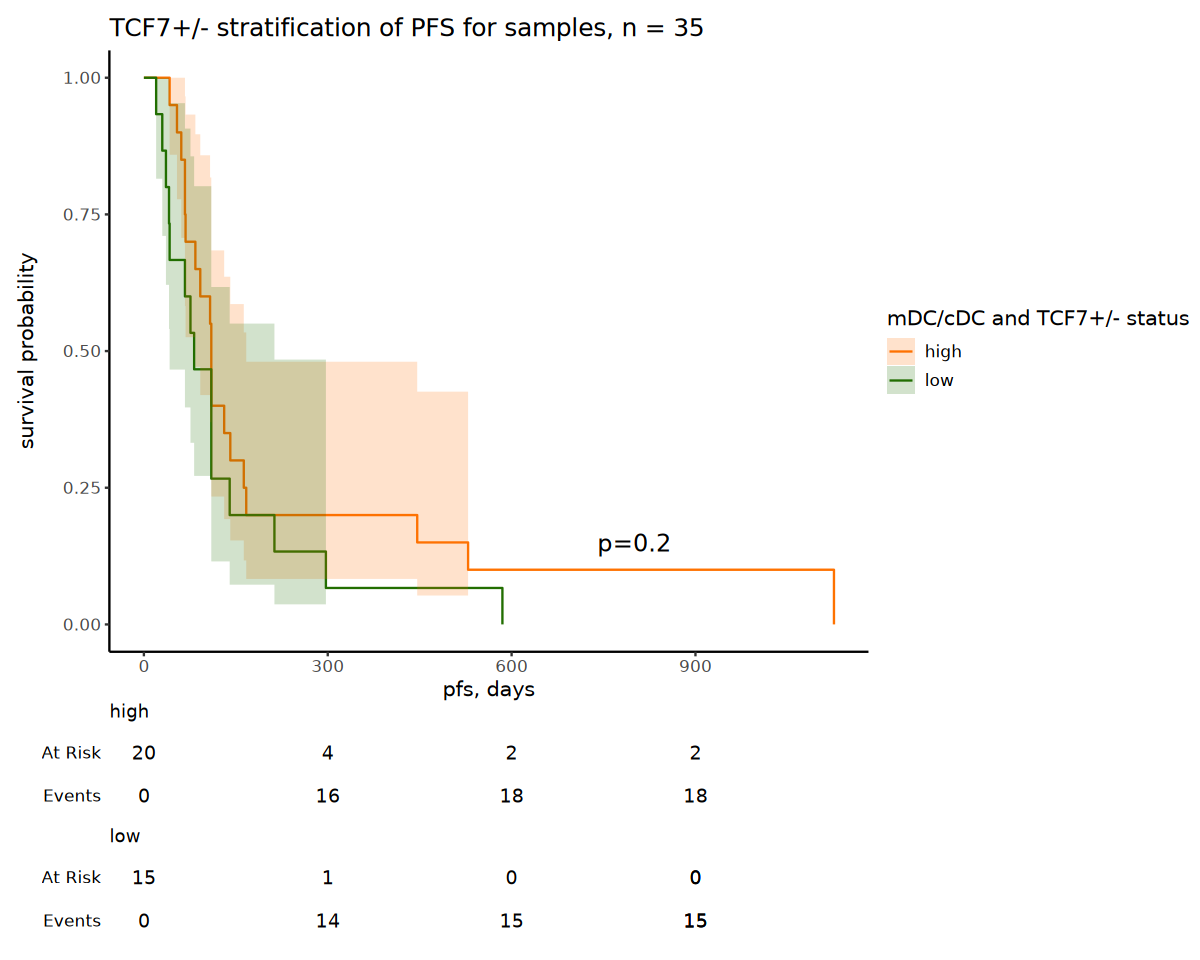

In [67]:
pfs_fit <- survfit2(
  Surv(pfs, censure_pfs) ~ TCF7_status,
  data = clinical_w_mDC_TCF7) 

str(pfs_fit)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(pfs_fit, 'pfs', "TCF7+/- stratification of PFS for samples, n = 35")

Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 33 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 33 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 33 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 33 rows.
ℹ Did you mean to use `annotate()`?”


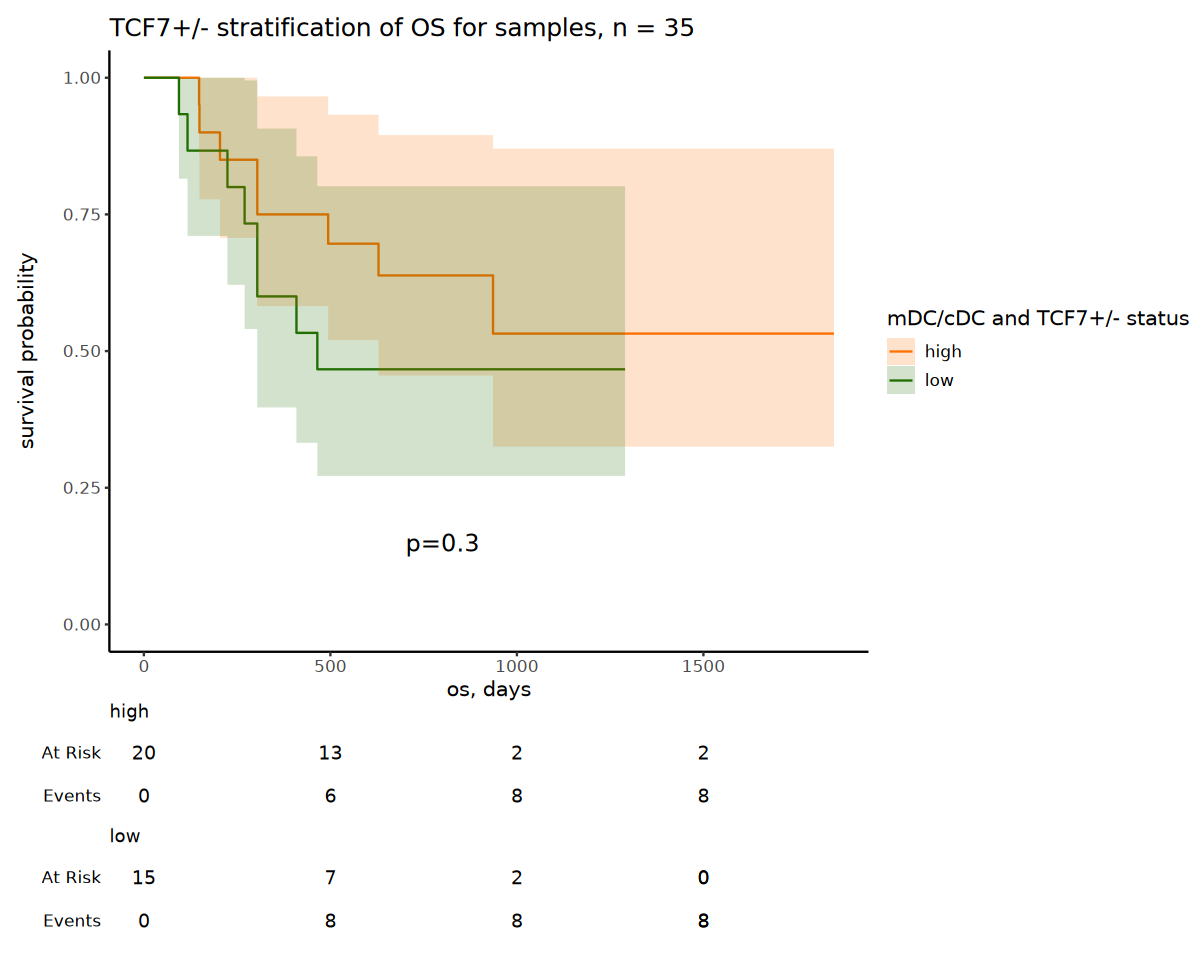

In [68]:
os_fit <- survfit2(
  Surv(os, censure_os) ~ TCF7_status,
  data = clinical_w_mDC_TCF7) 

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(os_fit, 'os', "TCF7+/- stratification of OS for samples, n = 35")

### b. with ICI (n = 29) - Supplementary Figure 3F

In [69]:
with_ICI_TCF7_samples <- clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$with_ICI == 'yes',]

List of 18
 $ n           : int [1:2] 17 12
 $ time        : num [1:25] 42 54 61 67 68 84 92 108 110 163 ...
 $ n.risk      : num [1:25] 17 16 15 14 12 11 10 9 8 6 ...
 $ n.event     : num [1:25] 1 1 1 2 1 1 1 1 2 1 ...
 $ n.censor    : num [1:25] 0 0 0 0 0 0 0 0 0 0 ...
 $ surv        : num [1:25] 0.941 0.882 0.824 0.706 0.647 ...
 $ std.err     : num [1:25] 0.0606 0.0886 0.1123 0.1566 0.1791 ...
 $ cumhaz      : num [1:25] 0.0588 0.1213 0.188 0.3308 0.4142 ...
 $ std.chaz    : num [1:25] 0.0588 0.0858 0.1087 0.1484 0.1702 ...
 $ strata      : Named int [1:2] 14 11
  ..- attr(*, "names")= chr [1:2] "TCF7_status=high" "TCF7_status=low"
 $ type        : chr "right"
 $ logse       : logi TRUE
 $ conf.int    : num 0.95
 $ conf.type   : chr "log"
 $ lower       : num [1:25] 0.836 0.742 0.661 0.519 0.455 ...
 $ upper       : num [1:25] 1 1 1 0.959 0.919 ...
 $ call        : language survfit(formula = Surv(pfs, censure_pfs) ~ TCF7_status, data = with_ICI_TCF7_samples)
 $ .Environment:<enviro

Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 27 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 27 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 27 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 27 rows.
ℹ Did you mean to use `annotate()`?”


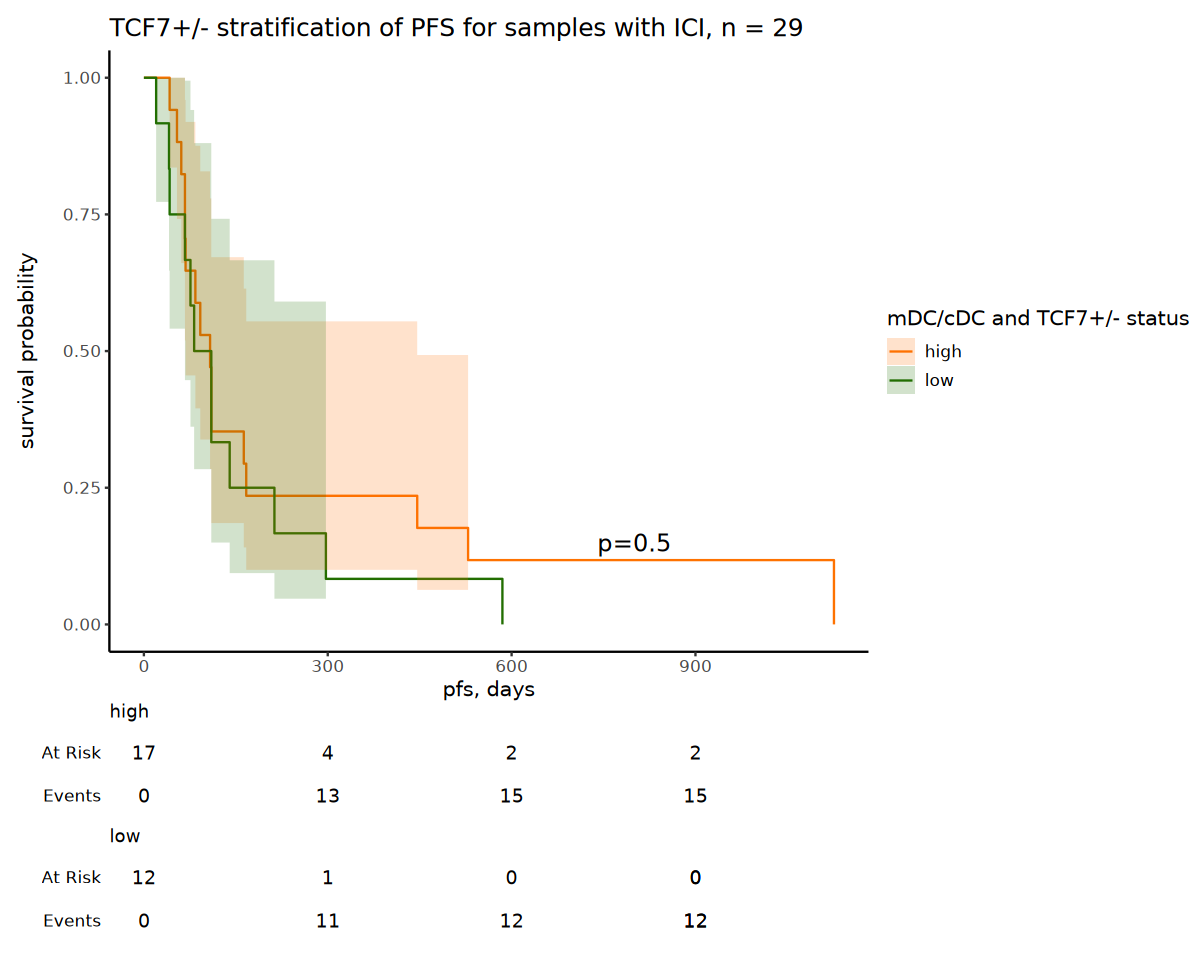

In [70]:
pfs_fit_w_ICI <- survfit2(
  Surv(pfs, censure_pfs) ~ TCF7_status,
  data = with_ICI_TCF7_samples) 

str(pfs_fit_w_ICI)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(pfs_fit_w_ICI, 'pfs', "TCF7+/- stratification of PFS for samples with ICI, n = 29")

List of 18
 $ n           : int [1:2] 17 12
 $ time        : num [1:25] 148 149 204 304 359 494 649 750 778 818 ...
 $ n.risk      : num [1:25] 17 16 15 14 12 11 10 9 8 7 ...
 $ n.event     : num [1:25] 1 1 1 2 0 1 0 0 0 0 ...
 $ n.censor    : num [1:25] 0 0 0 0 1 0 1 1 1 1 ...
 $ surv        : num [1:25] 0.941 0.882 0.824 0.706 0.706 ...
 $ std.err     : num [1:25] 0.0606 0.0886 0.1123 0.1566 0.1566 ...
 $ cumhaz      : num [1:25] 0.0588 0.1213 0.188 0.3308 0.3308 ...
 $ std.chaz    : num [1:25] 0.0588 0.0858 0.1087 0.1484 0.1484 ...
 $ strata      : Named int [1:2] 14 11
  ..- attr(*, "names")= chr [1:2] "TCF7_status=high" "TCF7_status=low"
 $ type        : chr "right"
 $ logse       : logi TRUE
 $ conf.int    : num 0.95
 $ conf.type   : chr "log"
 $ lower       : num [1:25] 0.836 0.742 0.661 0.519 0.519 ...
 $ upper       : num [1:25] 1 1 1 0.959 0.959 ...
 $ call        : language survfit(formula = Surv(os, censure_os) ~ TCF7_status, data = with_ICI_TCF7_samples)
 $ .Environment:<e

Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 27 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 27 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 27 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 27 rows.
ℹ Did you mean to use `annotate()`?”


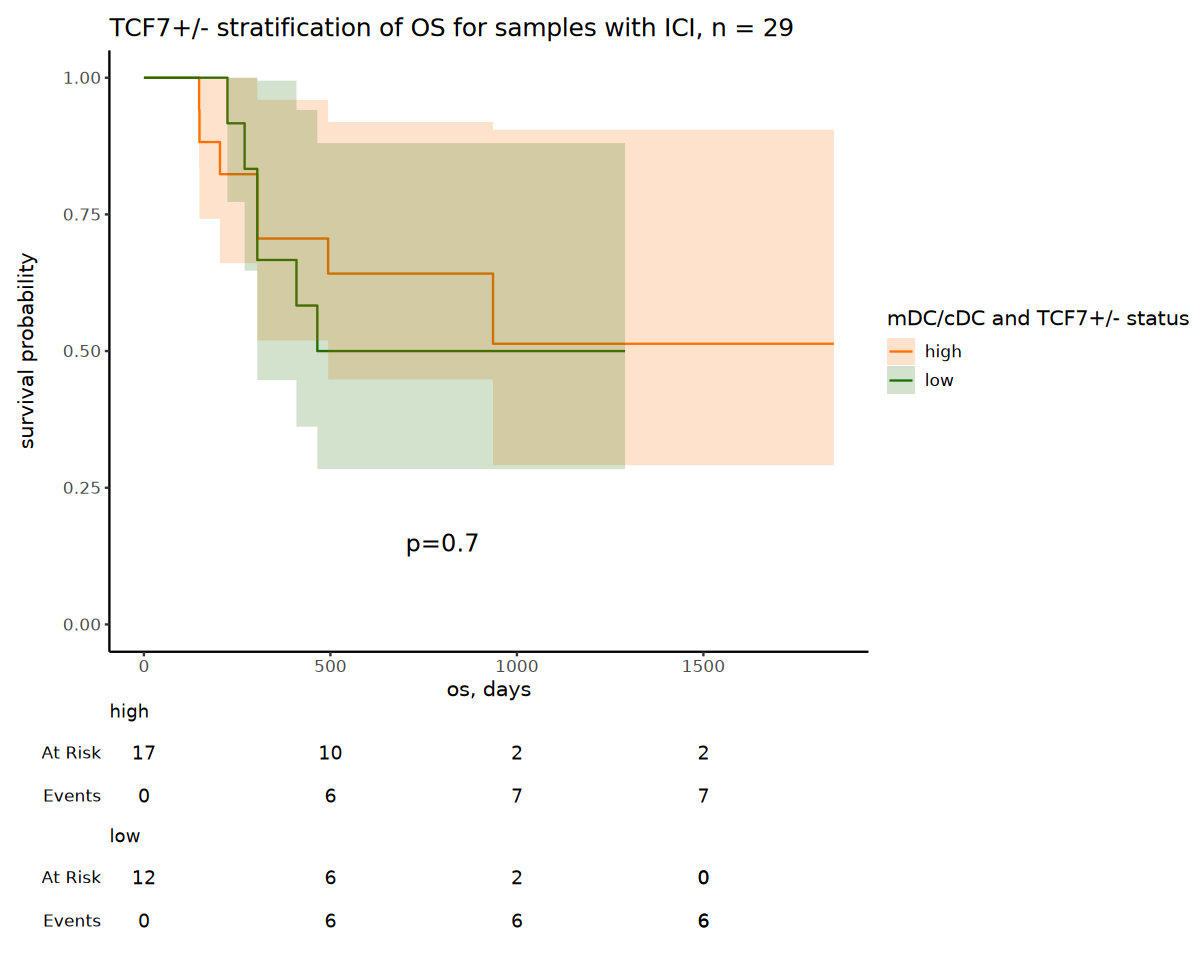

In [71]:
os_fit_w_ICI <- survfit2(
  Surv(os, censure_os) ~ TCF7_status,
  data = with_ICI_TCF7_samples) 

str(os_fit_w_ICI)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(os_fit_w_ICI, 'os', "TCF7+/- stratification of OS for samples with ICI, n = 29")

### 3. ICI only (n = 17)

In [72]:
ICI_only_TCF7_samples <- clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$ICI_only == 'yes',]

List of 18
 $ n           : int [1:2] 11 6
 $ time        : num [1:15] 42 54 61 67 92 ...
 $ n.risk      : num [1:15] 11 10 9 8 6 5 4 3 2 6 ...
 $ n.event     : num [1:15] 1 1 1 2 1 1 1 1 2 1 ...
 $ n.censor    : num [1:15] 0 0 0 0 0 0 0 0 0 0 ...
 $ surv        : num [1:15] 0.909 0.818 0.727 0.545 0.455 ...
 $ std.err     : num [1:15] 0.0953 0.1421 0.1846 0.2752 0.3303 ...
 $ cumhaz      : num [1:15] 0.0909 0.1909 0.302 0.552 0.7187 ...
 $ std.chaz    : num [1:15] 0.0909 0.1351 0.175 0.2487 0.2994 ...
 $ strata      : Named int [1:2] 9 6
  ..- attr(*, "names")= chr [1:2] "TCF7_status=high" "TCF7_status=low"
 $ type        : chr "right"
 $ logse       : logi TRUE
 $ conf.int    : num 0.95
 $ conf.type   : chr "log"
 $ lower       : num [1:15] 0.754 0.619 0.506 0.318 0.238 ...
 $ upper       : num [1:15] 1 1 1 0.936 0.868 ...
 $ call        : language survfit(formula = Surv(pfs, censure_pfs) ~ TCF7_status, data = ICI_only_TCF7_samples)
 $ .Environment:<environment: R_GlobalEnv> 
 - attr

Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 17 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 17 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 17 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 17 rows.
ℹ Did you mean to use `annotate()`?”


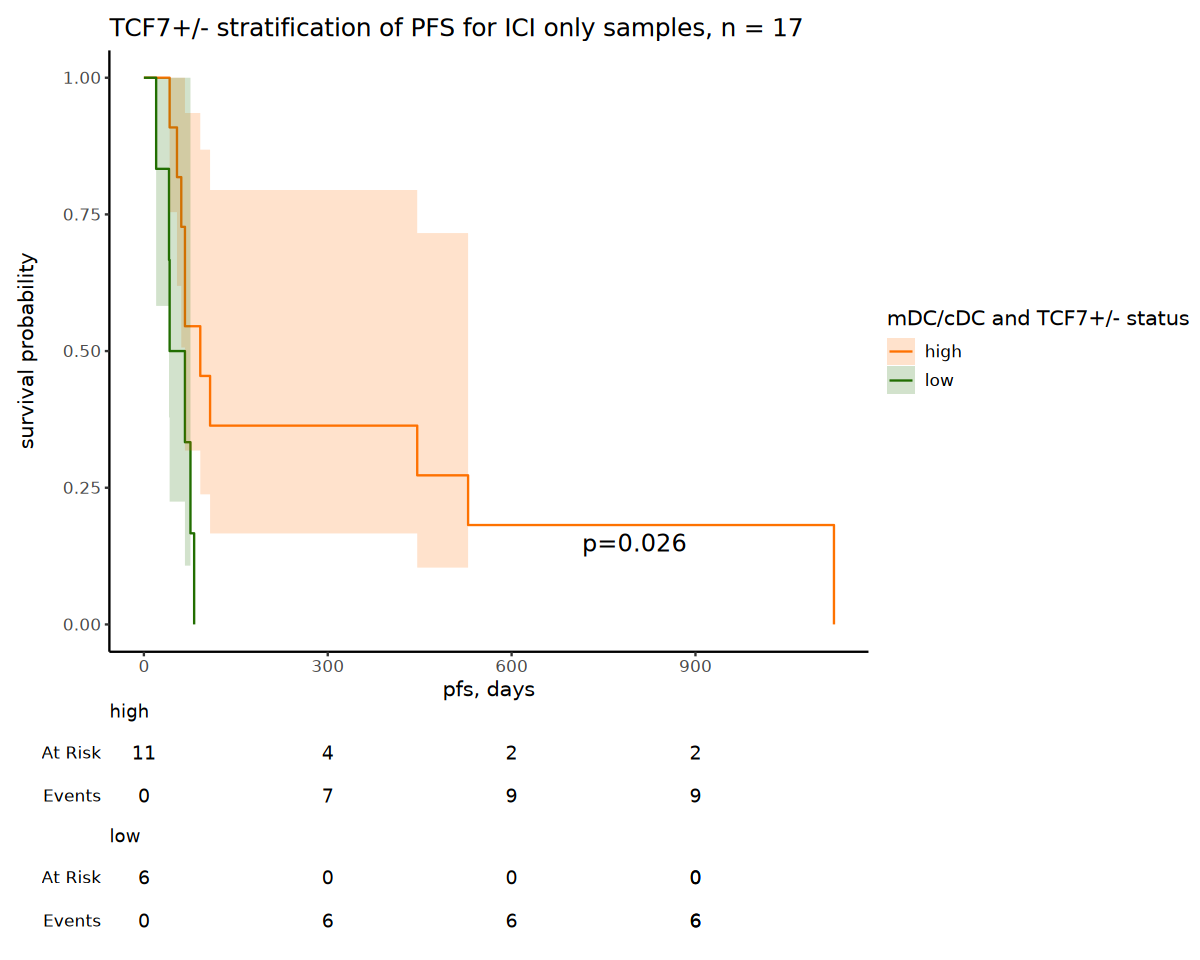

In [73]:
pfs_fit_only_ICI <- survfit2(
  Surv(pfs, censure_pfs) ~ TCF7_status,
  data = ICI_only_TCF7_samples) 

str(pfs_fit_only_ICI)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(pfs_fit_only_ICI, 'pfs', "TCF7+/- stratification of PFS for ICI only samples, n = 17")

List of 18
 $ n           : int [1:2] 11 6
 $ time        : num [1:15] 148 149 494 649 750 778 824 979 1850 224 ...
 $ n.risk      : num [1:15] 11 10 9 8 7 6 5 4 2 6 ...
 $ n.event     : num [1:15] 1 1 1 0 0 0 0 0 0 1 ...
 $ n.censor    : num [1:15] 0 0 0 1 1 1 1 2 2 0 ...
 $ surv        : num [1:15] 0.909 0.818 0.727 0.727 0.727 ...
 $ std.err     : num [1:15] 0.0953 0.1421 0.1846 0.1846 0.1846 ...
 $ cumhaz      : num [1:15] 0.0909 0.1909 0.302 0.302 0.302 ...
 $ std.chaz    : num [1:15] 0.0909 0.1351 0.175 0.175 0.175 ...
 $ strata      : Named int [1:2] 9 6
  ..- attr(*, "names")= chr [1:2] "TCF7_status=high" "TCF7_status=low"
 $ type        : chr "right"
 $ logse       : logi TRUE
 $ conf.int    : num 0.95
 $ conf.type   : chr "log"
 $ lower       : num [1:15] 0.754 0.619 0.506 0.506 0.506 ...
 $ upper       : num [1:15] 1 1 1 1 1 1 1 1 1 1 ...
 $ call        : language survfit(formula = Surv(os, censure_os) ~ TCF7_status, data = ICI_only_TCF7_samples)
 $ .Environment:<environment

Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 17 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 17 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 17 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 17 rows.
ℹ Did you mean to use `annotate()`?”


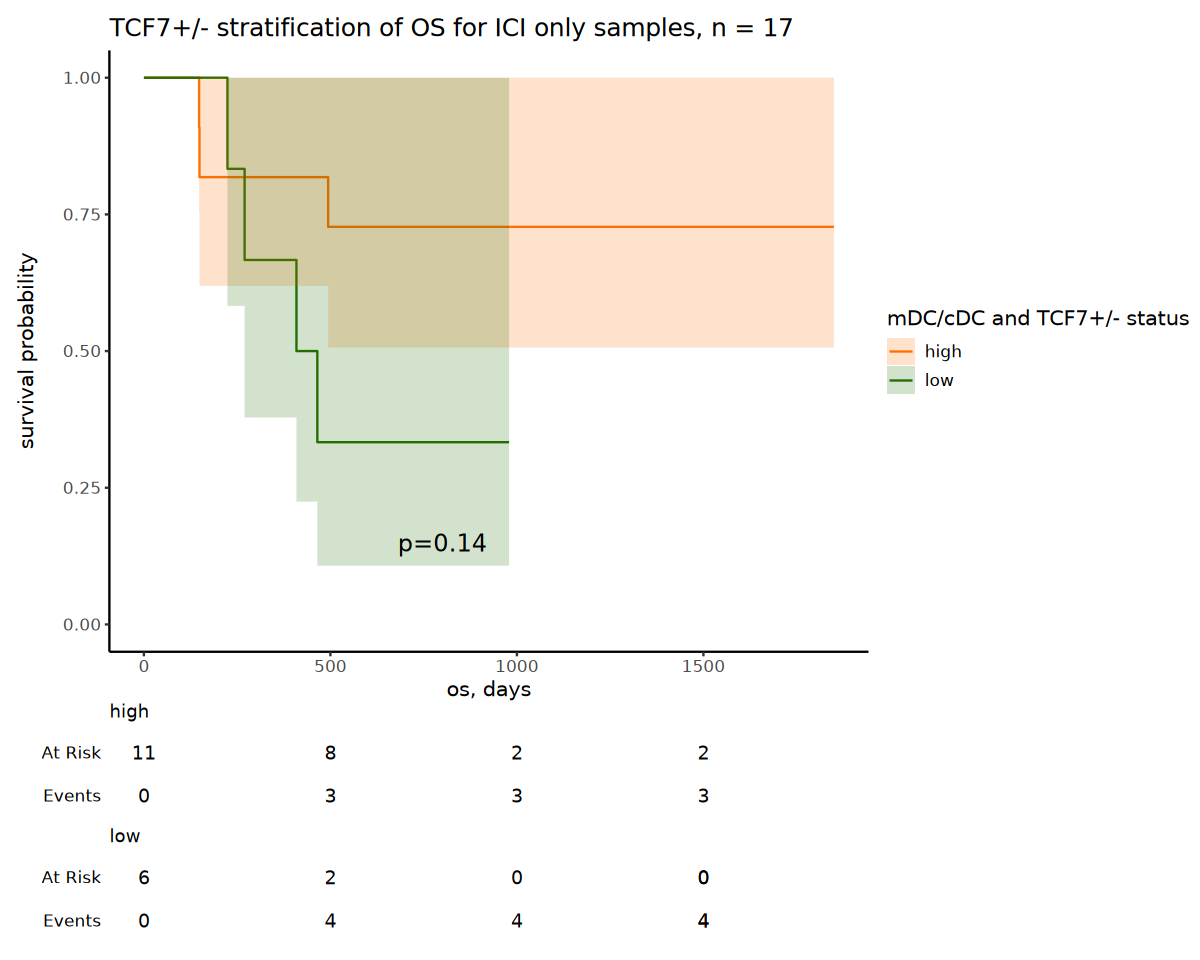

In [74]:
os_fit_only_ICI <- survfit2(
  Surv(os, censure_os) ~ TCF7_status,
  data = ICI_only_TCF7_samples) 

str(os_fit_only_ICI)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(os_fit_only_ICI, 'os', "TCF7+/- stratification of OS for ICI only samples, n = 17")

## Combining mDC/cDC and TCF7 ratio 

In [75]:
rownames(clinical_w_mDC_TCF7) <- clinical_w_mDC_TCF7$X
clinical_w_mDC_TCF7$X <- NULL

In [76]:
clinical_w_mDC_TCF7$mDC_TCF7_status <- "none"

In [77]:
#TCF7 > 0.1 and mDC/cDC > 0.185
clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$TCF7_data > 0.1 & clinical_w_mDC_TCF7$mDC_status == "high",]$mDC_TCF7_status = "high"
clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$mDC_TCF7_status == "none",]$mDC_TCF7_status <- "low"

### 1. all samples - Figure 3C

List of 18
 $ n           : int [1:2] 8 27
 $ time        : num [1:27] 67 68 84 141 163 ...
 $ n.risk      : num [1:27] 8 7 6 5 4 3 2 27 26 25 ...
 $ n.event     : num [1:27] 1 1 1 1 1 1 2 1 1 1 ...
 $ n.censor    : num [1:27] 0 0 0 0 0 0 0 0 0 0 ...
 $ surv        : num [1:27] 0.875 0.75 0.625 0.5 0.375 ...
 $ std.err     : num [1:27] 0.134 0.204 0.274 0.354 0.456 ...
 $ cumhaz      : num [1:27] 0.125 0.268 0.435 0.635 0.885 ...
 $ std.chaz    : num [1:27] 0.125 0.19 0.253 0.322 0.408 ...
 $ strata      : Named int [1:2] 7 20
  ..- attr(*, "names")= chr [1:2] "mDC_TCF7_status=high" "mDC_TCF7_status=low"
 $ type        : chr "right"
 $ logse       : logi TRUE
 $ conf.int    : num 0.95
 $ conf.type   : chr "log"
 $ lower       : num [1:27] 0.673 0.503 0.365 0.25 0.153 ...
 $ upper       : num [1:27] 1 1 1 1 0.917 ...
 $ call        : language survfit(formula = Surv(pfs, censure_pfs) ~ mDC_TCF7_status, data = clinical_w_mDC_TCF7)
 $ .Environment:<environment: R_GlobalEnv> 
 - attr(*, "cl

Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 29 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 29 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 29 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 29 rows.
ℹ Did you mean to use `annotate()`?”


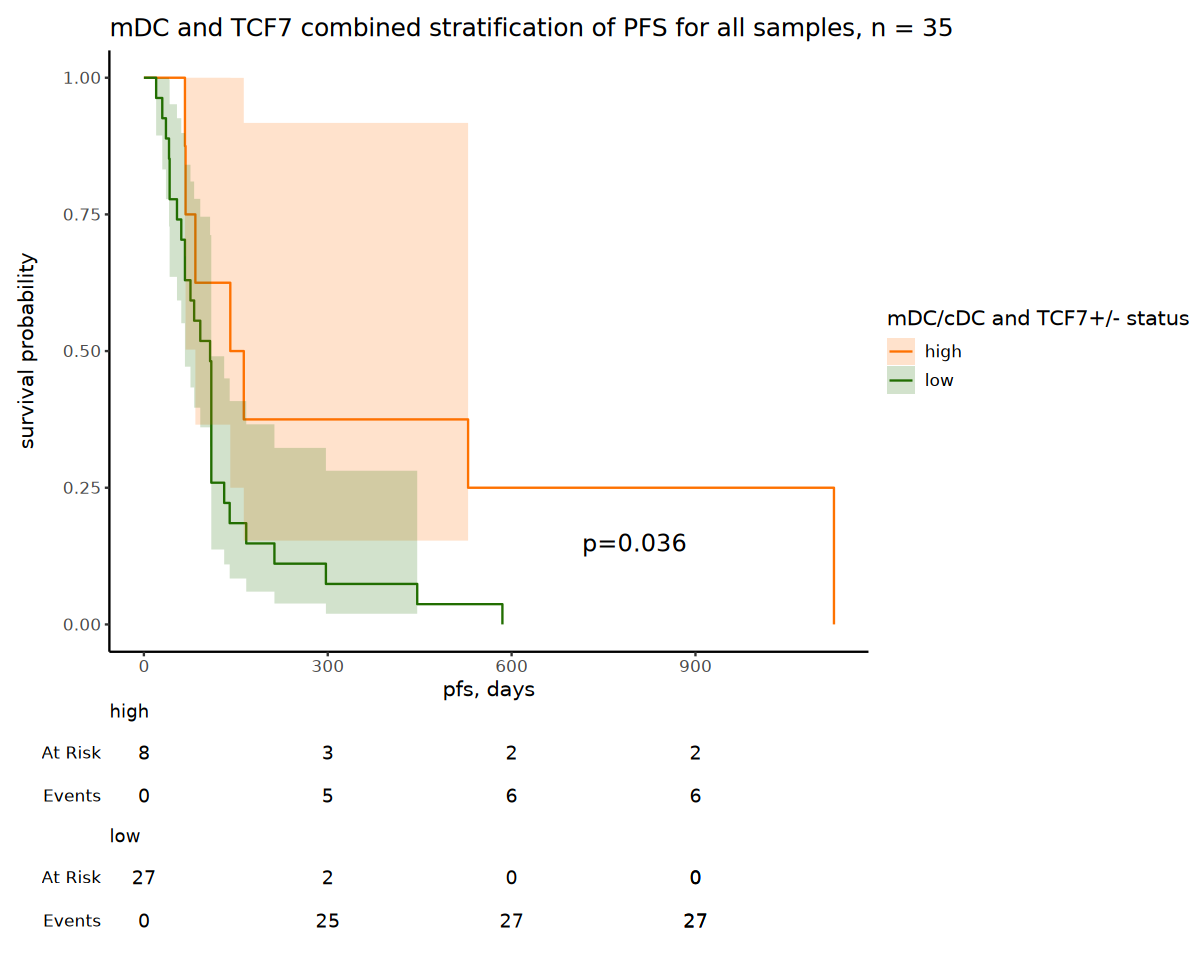

In [78]:
pfs_fit_combined <- survfit2(
  Surv(pfs, censure_pfs) ~ mDC_TCF7_status,
  data = clinical_w_mDC_TCF7) 

str(pfs_fit_combined)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(pfs_fit_combined, 'pfs', "mDC and TCF7 combined stratification of PFS for all samples, n = 35")

List of 18
 $ n           : int [1:2] 8 27
 $ time        : num [1:29] 204 359 649 818 979 980 1850 94 117 148 ...
 $ n.risk      : num [1:29] 8 7 6 5 4 3 2 27 26 25 ...
 $ n.event     : num [1:29] 1 0 0 0 0 0 0 1 1 1 ...
 $ n.censor    : num [1:29] 0 1 1 1 1 1 2 0 0 0 ...
 $ surv        : num [1:29] 0.875 0.875 0.875 0.875 0.875 ...
 $ std.err     : num [1:29] 0.134 0.134 0.134 0.134 0.134 ...
 $ cumhaz      : num [1:29] 0.125 0.125 0.125 0.125 0.125 ...
 $ std.chaz    : num [1:29] 0.125 0.125 0.125 0.125 0.125 ...
 $ strata      : Named int [1:2] 7 22
  ..- attr(*, "names")= chr [1:2] "mDC_TCF7_status=high" "mDC_TCF7_status=low"
 $ type        : chr "right"
 $ logse       : logi TRUE
 $ conf.int    : num 0.95
 $ conf.type   : chr "log"
 $ lower       : num [1:29] 0.673 0.673 0.673 0.673 0.673 ...
 $ upper       : num [1:29] 1 1 1 1 1 1 1 1 1 1 ...
 $ call        : language survfit(formula = Surv(os, censure_os) ~ mDC_TCF7_status, data = clinical_w_mDC_TCF7)
 $ .Environment:<environme

Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 31 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 31 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 31 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 31 rows.
ℹ Did you mean to use `annotate()`?”


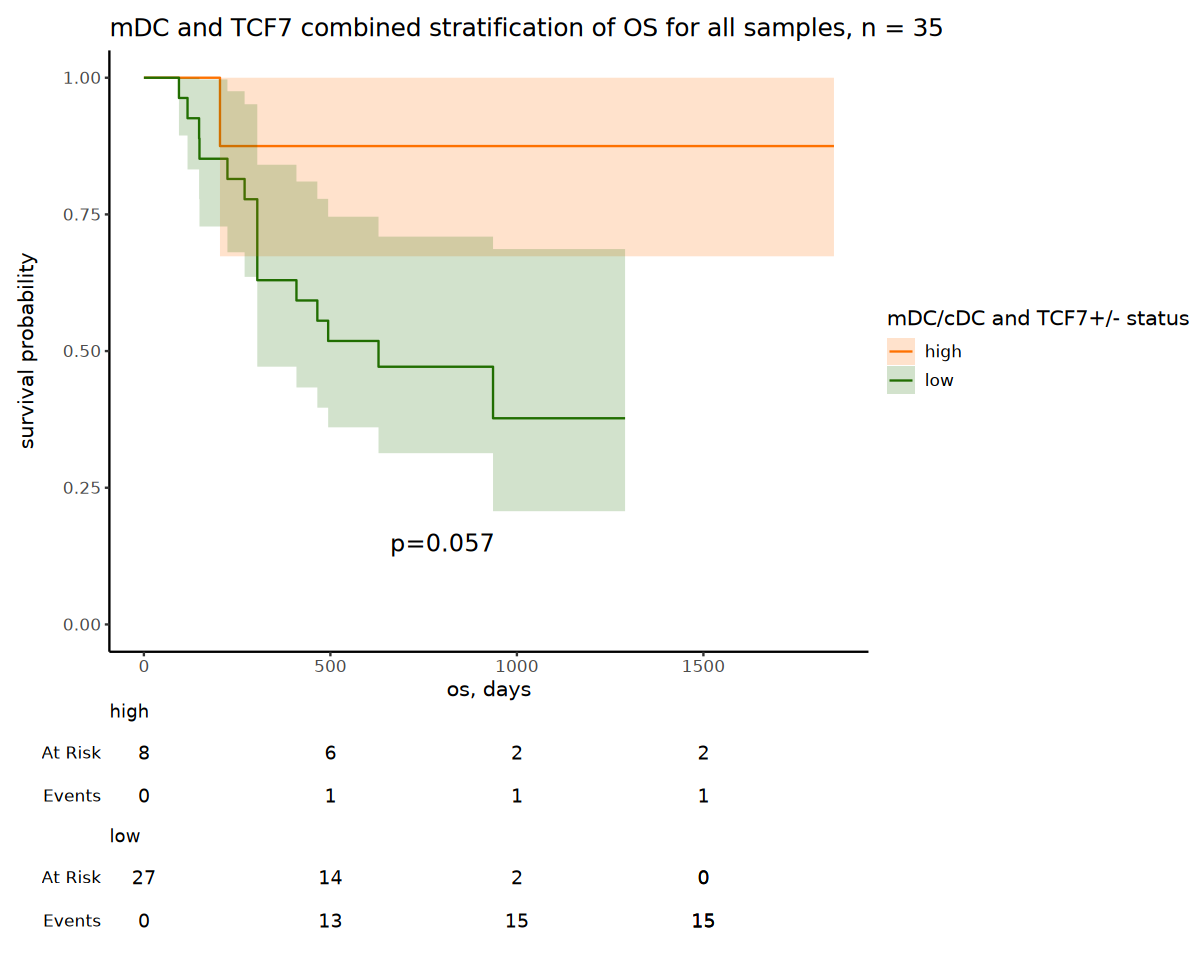

In [79]:
os_fit_combined <- survfit2(
  Surv(os, censure_os) ~ mDC_TCF7_status,
  data = clinical_w_mDC_TCF7) 

str(os_fit_combined)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(os_fit_combined, 'os', "mDC and TCF7 combined stratification of OS for all samples, n = 35")

### 2. with ICI samples (29)

In [80]:
#subset 
with_ICI_mDC_TCF7_samples <- clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$with_ICI == 'yes',]
ICI_only_mDC_TCF7_samples <- clinical_w_mDC_TCF7[clinical_w_mDC_TCF7$ICI_only == 'yes',]

List of 18
 $ n           : int [1:2] 7 22
 $ time        : num [1:23] 67 68 84 163 529 ...
 $ n.risk      : num [1:23] 7 6 5 4 3 2 22 21 20 18 ...
 $ n.event     : num [1:23] 1 1 1 1 1 2 1 1 2 1 ...
 $ n.censor    : num [1:23] 0 0 0 0 0 0 0 0 0 0 ...
 $ surv        : num [1:23] 0.857 0.714 0.571 0.429 0.286 ...
 $ std.err     : num [1:23] 0.154 0.239 0.327 0.436 0.598 ...
 $ cumhaz      : num [1:23] 0.143 0.31 0.51 0.76 1.093 ...
 $ std.chaz    : num [1:23] 0.143 0.22 0.297 0.388 0.512 ...
 $ strata      : Named int [1:2] 6 17
  ..- attr(*, "names")= chr [1:2] "mDC_TCF7_status=high" "mDC_TCF7_status=low"
 $ type        : chr "right"
 $ logse       : logi TRUE
 $ conf.int    : num 0.95
 $ conf.type   : chr "log"
 $ lower       : num [1:23] 0.6334 0.4471 0.3008 0.1822 0.0886 ...
 $ upper       : num [1:23] 1 1 1 1 0.922 ...
 $ call        : language survfit(formula = Surv(pfs, censure_pfs) ~ mDC_TCF7_status, data = with_ICI_mDC_TCF7_samples)
 $ .Environment:<environment: R_GlobalEnv> 
 

Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 25 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 25 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 25 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in ggplot2::geom_blank():
“All aesthetics have length 1, but the data has 25 rows.
ℹ Did you mean to use `annotate()`?”


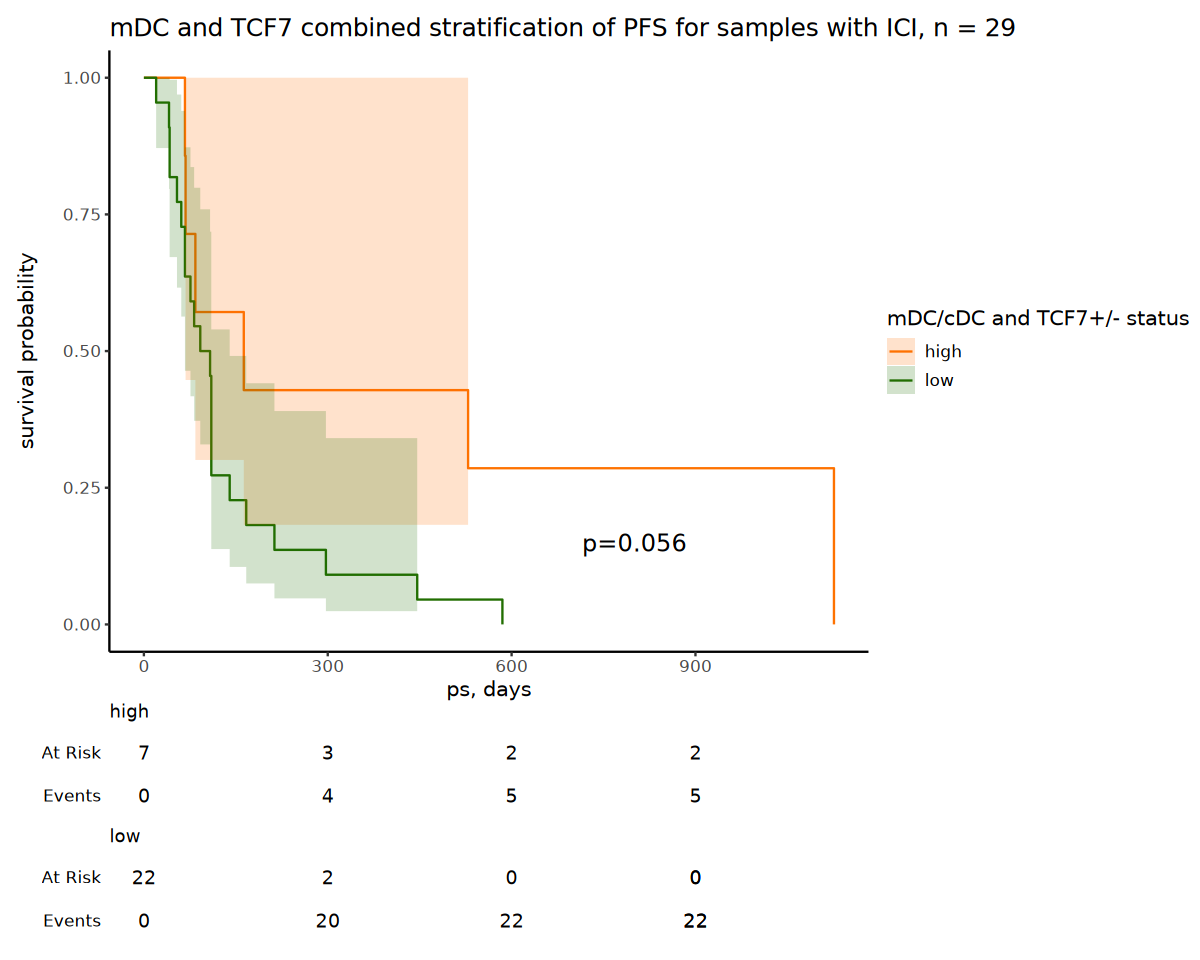

In [81]:
pfs_fit_combined_w_ICI <- survfit2(
  Surv(pfs, censure_pfs) ~ mDC_TCF7_status,
  data = with_ICI_mDC_TCF7_samples) 

str(pfs_fit_combined_w_ICI)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(pfs_fit_combined_w_ICI, 'ps', "mDC and TCF7 combined stratification of PFS for samples with ICI, n = 29")

In [82]:
os_fit_combined_w_ICI <- survfit2(
  Surv(os, censure_os) ~ _TCF7_status,
  data = with_ICI_mDC_TCF7_samples) 

str(os_fit_combined_w_ICI)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(os_fit_combined_w_ICI, 'os', "mDC and TCF7 combined stratification of OS for samples with ICI, n = 29")

ERROR: Error in parse(text = x, srcfile = src): <text>:2:27: unexpected symbol
1: os_fit_combined_w_ICI <- survfit2(
2:   Surv(os, censure_os) ~ _TCF7_status
                             ^


### 3. ICI only (n = 17)

In [ ]:
pfs_fit_combined_ICI_only <- survfit2(
  Surv(pfs, censure_pfs) ~ _TCF7_status,
  data = ICI_only_mDC_TCF7_samples) 

str(pfs_fit_combined_ICI_only)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(pfs_fit_combined_ICI_only, 'ps', "mDC and TCF7 combined stratification of PFS for ICI only samples, n = 17")

In [ ]:
os_fit_combined_ICI_only <- survfit2(
  Surv(os, censure_os) ~ _TCF7_status,
  data = ICI_only_mDC_TCF7_samples) 

str(os_fit_combined_ICI_only)

options(repr.plot.height = 8, repr.plot.width=10)

plot_survival(os_fit_combined_ICI_only, 'os', "mDC and TCF7 combined stratification of OS for ICI only samples, n = 17")